In [ ]:
""" Simple Video Stream """
# from IPython.display import Image, display


# Stream_Url = "    Your Tunnel Url    "
# # ----------------------------------------------------

# video_url = f"{Stream_Url}/video    or any other poath you set up in flask server."

# print(f"Attempting to connect to: {video_url}")

# display(Image(url=video_url, width=640))

In [2]:
!pip install -q transformers timm matplotlib
# !pip install -q transformers timm matplotlib
# !pip install torch opencv-python-headless pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.2 MB/s eta 0:00:00


In [1]:
import requests
import urllib.request
import cv2
import torch
import numpy as np
from PIL import Image as PILImage
from transformers import DPTForDepthEstimation, DPTImageProcessor
from google.colab.patches import cv2_imshow
from IPython.display import display, clear_output, Image, HTML, Javascript
from time import sleep
import matplotlib.pyplot as plt
import io
import base64
from threading import Thread
from IPython.display import display, HTML, Javascript
import time

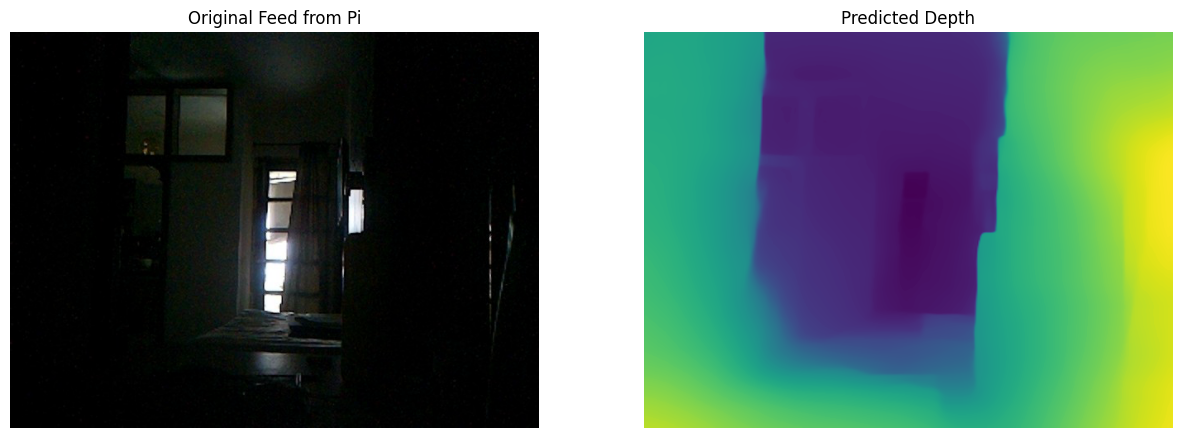

Graph time 0.4360198974609375  seconds
Stream stopped by user.
Stream resources released.


In [ ]:

# Switch to GPU instance for performance.

class VideoStream:
    """A class to read frames from a video stream in a dedicated thread."""
    def __init__(self, src=0):
        self.stream = cv2.VideoCapture(src)
        (self.grabbed, self.frame) = self.stream.read()
        self.stopped = False
    def start(self):
        Thread(target=self.update, args=()).start()
        return self
    def update(self):
        while True:
            if self.stopped:
                self.stream.release()
                return
            (self.grabbed, self.frame) = self.stream.read()
    def read(self):
        return self.frame
    def stop(self):
        self.stopped = True
# -------------------------------------------------------------

model_name = "Intel/dpt-large"
processor = DPTImageProcessor.from_pretrained(model_name)
model = DPTForDepthEstimation.from_pretrained(model_name)

" Use cuda for performance on CPU it takes about 30-60 sec to process 1 frame  tested on 640 resolution"
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Stream_URL = "    Your Tunnel Url Here    "
video_url = f"{Stream_URL}/video    or any other poath you set up in flask server."

vs = VideoStream(src=video_url).start()
import time
time.sleep(1.0)

fig, ax = plt.subplots(1, 2, figsize=(15, 7))

try:
    while True:
        frame = vs.read()
        if frame is None:
            print("Waiting for frame...")
            time.sleep(0.5)
            continue

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = PILImage.fromarray(rgb_frame)

        start = time.time()
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )
        output = prediction.squeeze().cpu().numpy()
        formatted = (output * 255 / np.max(output)).astype("uint8")
        depth_map = PILImage.fromarray(formatted)
        end_time = time.time()
        print("Model time", end_time - start, " seconds")

        clear_output(wait=True)
        start = time.time()
        ax[0].imshow(image)
        ax[0].set_title("Original Feed from Pi")
        ax[0].axis('off')

        ax[1].imshow(depth_map, cmap='viridis')
        ax[1].set_title("Predicted Depth")
        ax[1].axis('off')

        display(fig)
        end_time = time.time()
        print("Graph time", end_time - start, " seconds")

except KeyboardInterrupt:
    print("Stopped")

finally:
    vs.stop()
    plt.close(fig)

In [ ]:
""" Using Numpy here to desplay images is much faster than using matpotlib while on gpu model was taking 0.22 seconds to
    process one frame and matplotlib was taking 2.2 ~ seconds just fro plotting it (timings for cpu wiil be lesser for matplotlib),
    so instead using Numpy is giving a huge boost, taking almost no time for rendering."""



class VideoStream:
    """A class to read frames from a video stream in a dedicated thread."""
    def __init__(self, src=0):
        self.stream = cv2.VideoCapture(src)
        (self.grabbed, self.frame) = self.stream.read()
        self.stopped = False
    def start(self):
        Thread(target=self.update, args=()).start()
        return self
    def update(self):
        while True:
            if self.stopped:
                self.stream.release()
                return
            (self.grabbed, self.frame) = self.stream.read()
    def read(self):
        return self.frame
    def stop(self):
        self.stopped = True
# -------------------------------------------------------------

def js_display_image(array, img_id='stream_img'):
    """
    Converts a NumPy array to a JPEG, encodes it in Base64, and
    returns a Javascript object to update an <img> tag.
    """
    image = PILImage.fromarray(cv2.cvtColor(array, cv2.COLOR_BGR2RGB))
    buffer = io.BytesIO()

    image.save(buffer, format='jpeg')
    b64_string = base64.b64encode(buffer.getvalue()).decode('utf-8')

    js_code = f"document.getElementById('{img_id}').src = 'data:image/jpeg;base64,{b64_string}';"

    return Javascript(js_code)
# ---------------------------------------------
model_name = "Intel/dpt-large"
processor = DPTImageProcessor.from_pretrained(model_name)
model = DPTForDepthEstimation.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Stream_URL = "    Your Tunnel Url Here    "
video_url = f"{Stream_URL}/video    or any other poath you set up in flask server."

vs = VideoStream(src=video_url).start()
time.sleep(1.0)

IMAGE_ID = 'stream_image'
display(HTML(f'<img id="{IMAGE_ID}" src="" style="width: 80%;">'))

try:
     while True:
        frame = vs.read()
        if frame is None:
            time.sleep(0.01)
            continue

        original_display_frame = frame.copy()
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image = PILImage.fromarray(rgb_frame)


        inputs = processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
            predicted_depth = outputs.predicted_depth

        prediction = torch.nn.functional.interpolate(
            predicted_depth.unsqueeze(1),
            size=image.size[::-1],
            mode="bicubic",
            align_corners=False,
        )
        output = prediction.squeeze().cpu().numpy()
        formatted = (output * 255 / np.max(output)).astype("uint8")

        # Grayscale image:
        # depth_display_frame = cv2.cvtColor(formatted, cv2.COLOR_GRAY2BGR)
        # Intensity color
        depth_display_frame = cv2.applyColorMap(formatted, cv2.COLORMAP_VIRIDIS)
        combined_image = np.hstack((original_display_frame, depth_display_frame))
        display(js_display_image(combined_image, img_id=IMAGE_ID))

except KeyboardInterrupt:
    print("\nStopped")

finally:
    vs.stop()


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Stopped
